# Grammar parameter fitting via VI

Try to fit the parameters of this grammar, given a library of observed points, with a VI strategy that evolves parameterized posteriors over the poses of the nodes explaining each observation.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_fixed_structure.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)

def make_orthographic(xmin,  xmax, ymin, ymax, camera_position):
    # Taken from https://github.com/RobotLocomotion/drake/blob/master/bindings/pydrake/systems/meshcat_visualizer.py
    camera = meshcat_geom.OrthographicCamera(
        left=xmin, right=xmax, top=ymax, bottom=ymin, near=-1000, far=1000)
    vis['/Cameras/default/rotated'].set_object(camera)
    vis['/Cameras/default'].set_transform(
        RigidTransform(camera_position).GetAsMatrix4())

    # Lock the orbit controls.
    vis['/Cameras/default/rotated/<object>'].set_property(
        "position", [0, 0, 0])
    vis['/Background'].set_property("visible", False)
    vis['/Grid'].set_property("visible", False)
    vis['/Axes'].set_property("visible", False)
        
make_orthographic(-2, 2, -2, 2, np.array([0., 0., 1.]))

from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Meshcat url:  http://127.0.0.1:7000/static/


  0%|          | 0/50 [00:00<?, ?it/s]

Saving...
Loading...
Loaded 50 scenes.


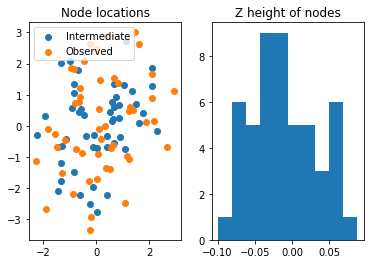

In [5]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 50
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = RootNode,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in tqdm(range(N_samples)):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    print("Saving...")
    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

print("Loading...")
with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)

plt.figure()
plt.subplot(1, 2, 1)
plt.title("Node locations")
l = get_all_node_xyzs([sample[0] for sample in samples], HiddenNode)
plt.scatter(l[:, 0], l[:, 1], label="Intermediate")
l = get_all_node_xyzs([sample[0] for sample in samples], VisibleNode)
plt.scatter(l[:, 0], l[:, 1], label="Observed")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(l[:, 2])
plt.title("Z height of nodes")


# And draw some of the trees in visualizer; not too many, it makes it slow.
for k in range(10):
    draw_scene_tree_contents_meshcat(samples[k][0], zmq_url=vis.window.zmq_url, prefix="dataset/contents/sample_%d" % k)
    draw_scene_tree_structure_meshcat(samples[k][0], zmq_url=vis.window.zmq_url, prefix="dataset/structures/sample_%d" % k)

# Pseudo-VI algo

<!---
As is standard for VI, we'll create a variational posterior approximation $q_\phi(z)$, where $z$ referes to the set of latent variables. $z$ can be broken down into $\{z_k\}$ for each observation $k$ in our dataset. (I'm not planning on amortizing yet.) Concretely, ${z_k}$ is going to be the continuous random poses of each node in the supertree for observation $k$.

VI would work straight from the ELBO:
$$
\arg\max_{\theta, \phi} \mathbb{E}_{q_\phi(z)} \left[ \log p_\theta(x, z) - \log q_\phi(z) \right]
$$

But that's *not* what we're doing. How do I write what we're actually doing?
-->

Initialize a variational posterior $q_\phi(z_k)$ for each observation $k$, where $z_k$ describes a distribution over the latent poses for each node in the supertree corresponding to observation $k$. Also initialize model parameters $\theta$ for any parameters in the grammar.

Repeatedly:
1. Find the MAP tree structure $t_k$ for all observations with the MIP using the current $\theta$.
2. For the nodes that show up in $t_k$, set the posterior parameters $\phi$ to be tightly peaked around the MAP-optimal setting.
3. Run a few gradient step updates on the ELBO evaluated using discrete tree structure $t_k$ and continuous poses sampled from the variational posterior.


In [65]:
torch.random.manual_seed(42)
random_grammar = SpatialSceneGrammar(
    root_node_type = RootNode,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)
svi = SVIWrapper(random_grammar, [sample[1] for sample in samples])
svi.do_iterated_vi_fitting(
    major_iterations=10, minor_iterations=50,
    tqdm=tqdm, num_elbo_samples=1, subsample=False, clip=None,
    base_lr=0.1
)

Major iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/50 [00:00<?, ?it/s]

Minor iteration:   0%|          | 0/50 [00:00<?, ?it/s]

0:xyz:mean final: tensor([ 0.0960,  0.0245, -0.0111])
0:xyz:variance final: tensor([3.6222e-01, 6.0880e-01, 3.4679e-04])


0:xyz:mean final: tensor([ 0.0960,  0.0245, -0.0038])
0:xyz:variance final: tensor([0.3622, 0.6088, 0.0017])


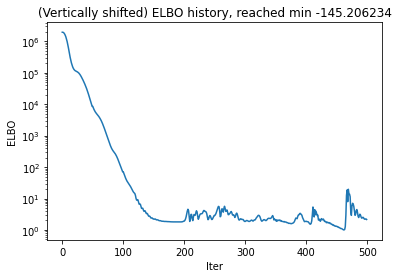

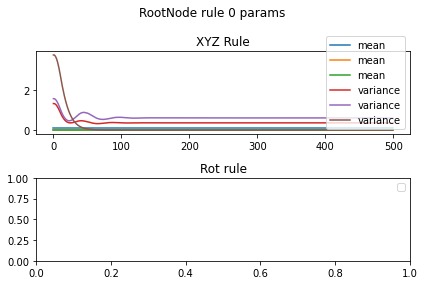

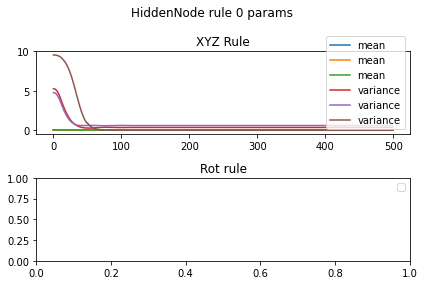

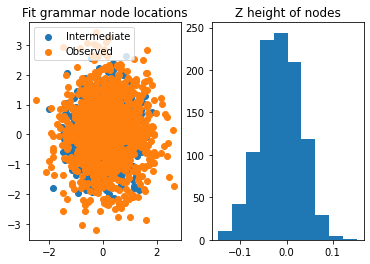

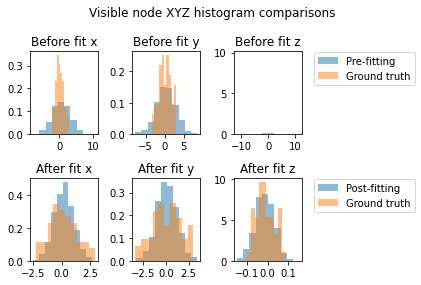

In [68]:
def plot_post_fit_tree_samples(self, N_samples=100):
    pre_fit_samples= []
    self.grammar.load_state_dict(self.grammar_major_iters[0][0])
    for k in range(N_samples):
        pre_fit_samples.append(self.grammar.sample_tree(detach=True))
    fit_samples = []
    self.grammar.load_state_dict(self.grammar_major_iters[-1][-1])
    for k in range(N_samples):
        fit_samples.append(self.grammar.sample_tree(detach=True))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Fit grammar node locations")
    l = get_all_node_xyzs(fit_samples, HiddenNode)
    plt.scatter(l[:, 0], l[:, 1], label="Intermediate")
    l = get_all_node_xyzs(fit_samples, VisibleNode)
    plt.scatter(l[:, 0], l[:, 1], label="Observed")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.hist(l[:, 2])
    plt.title("Z height of nodes")

    plt.figure()
    plt.suptitle("Visible node XYZ histogram comparisons")

    gt_l = get_all_node_xyzs([sample[0] for sample in samples], VisibleNode)
    fit_l = get_all_node_xyzs([sample for sample in fit_samples], VisibleNode)
    pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], VisibleNode)
    # Pre fit
    for k in range(3):
        plt.subplot(2, 3, k+1)
        plt.title("Before fit %s" % "xyz"[k:(k+1)])
        plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
        plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
        if k == 2:
            plt.legend(bbox_to_anchor=(1.1, 1.05))

    for k in range(3):
        plt.subplot(2, 3, k+1+3)
        plt.title("After fit %s" % "xyz"[k:(k+1)])
        plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
        plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
        if k == 2:
            plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()

svi.plot_elbo_history()
svi.plot_grammar_parameter_history(RootNode)
svi.plot_grammar_parameter_history(HiddenNode)

plot_post_fit_tree_samples(svi, N_samples=1000)

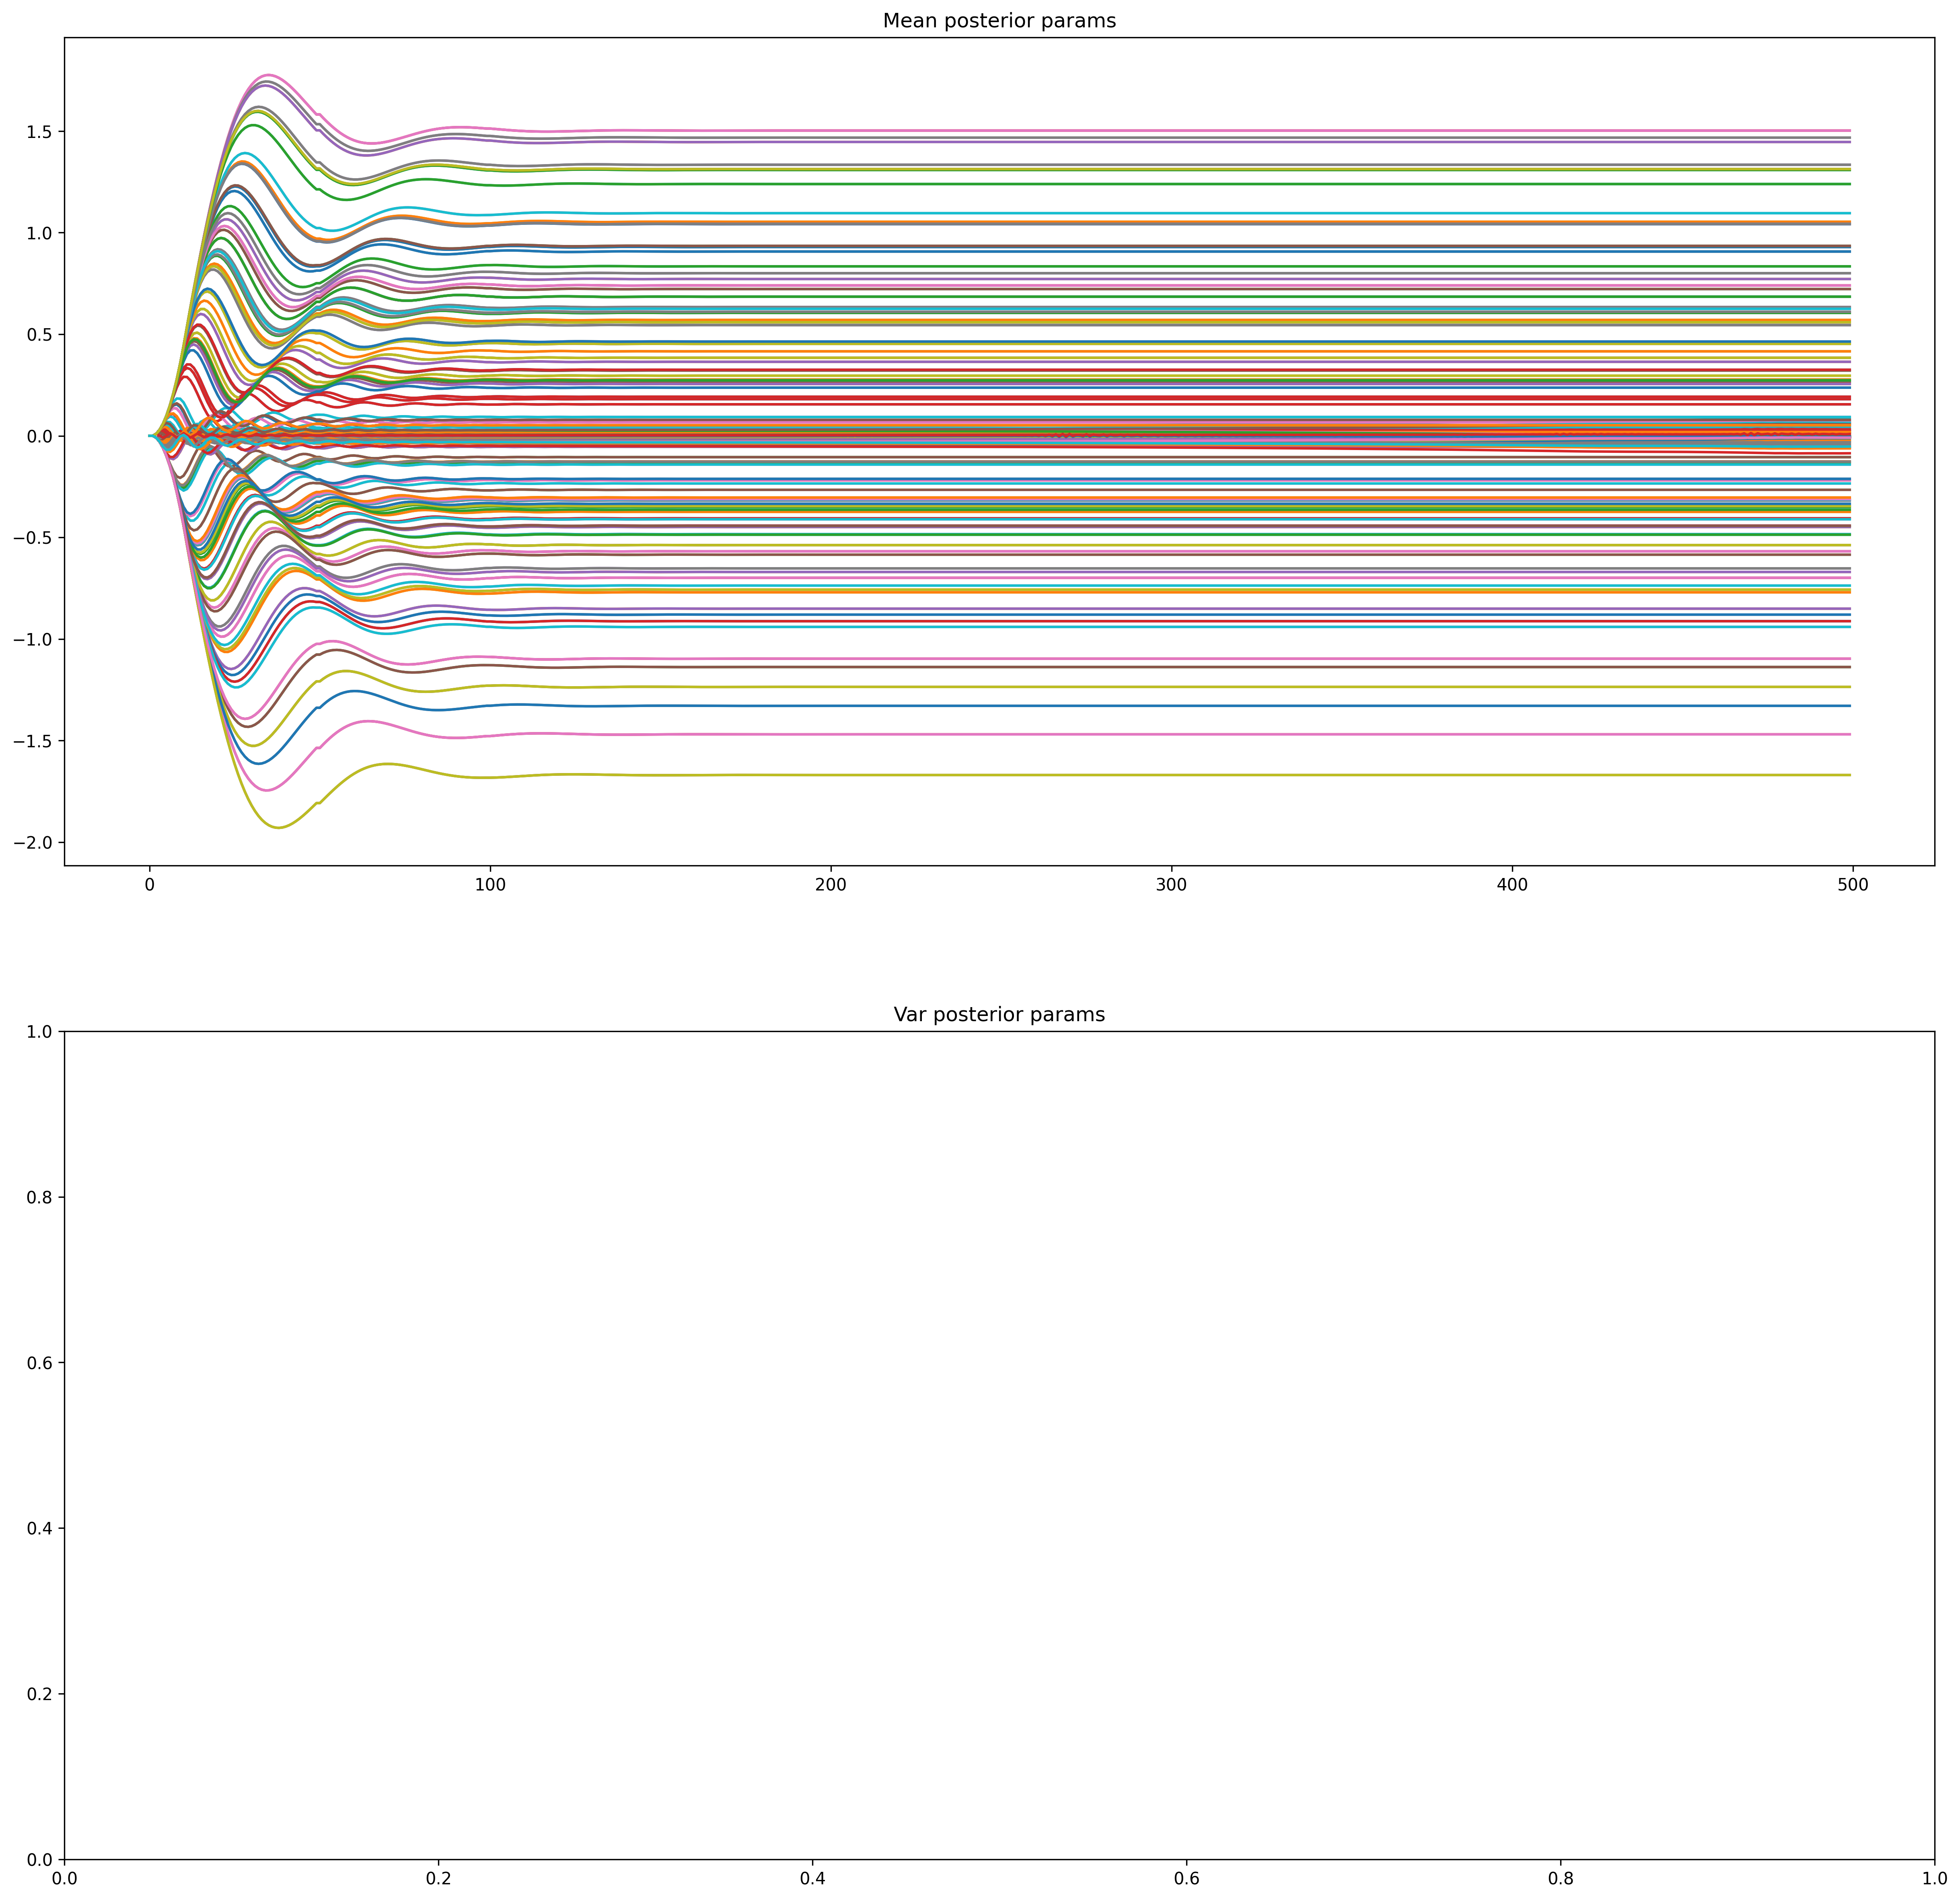

In [69]:
# Plot variational posterior parameters over optimization
def plot_posterior_params(self):
    svi_param_hists = [{} for k in range(len(self.observed_node_sets))]
    for posteriors, posterior_histories in self.posterior_major_iters:
        for state_dict in posterior_histories:
            posteriors.load_state_dict(state_dict)
            for k, posterior in enumerate(posteriors):
                hist_dict = svi_param_hists[k]
                for key, value in posterior.named_parameters():
                    if key not in hist_dict:
                        hist_dict[key] = []
                    hist_dict[key].append(deepcopy(value.detach()))
    plt.figure(dpi=300).set_size_inches(20, 20)
    ax1 = plt.subplot(2, 1, 1)
    plt.title("Mean posterior params")
    ax2 = plt.subplot(2, 1, 2)
    plt.title("Var posterior params")
    for param_hist in svi_param_hists:
        for key, value in param_hist.items():
            data = torch.stack(value).detach().numpy()
            if "mean" in key.split(".")[0]:
                ax1.plot(data)
            else:
                ax2.plot(data)

plot_posterior_params(svi)
